In [1]:
import pandas as pd
import numpy as np

from math import sqrt

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
interactome_df = pd.read_csv('./data/Interactome_human.tsv', sep='\t', header=None)
G = nx.from_pandas_edgelist(interactome_df, 0, 1, edge_attr=True)

candidates_MMAF = pd.read_pickle("./data/candidateGenesList_MMAF.p")

nonCandidates_MMAF = [n for n in list(G.nodes) if n not in candidates_MMAF]

In [38]:
def candidates_in_neighbourhood(G, candidates, node):
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G] if x in candidates]
    # candidates_in_neighbourhood = [x if x in candidates else -1 for x in [n for n in sub_G]]
    if candidates_in_neighbourhood:
        return candidates_in_neighbourhood
    else:
        return []

In [72]:
# modified version of eigenvector centrality that takes the number of candidates in the neighbourhood into account

def katz_centrality(G, alpha=1, beta=1, max_iter=100, tol=1.0e-6, nstart=None, 
                           weight='weight'): 
    """
    Parameters 
    ---------- 
    G : graph 
      A networkx graph 
  
    max_iter : integer, optional 
      Maximum number of iterations in power method. 
  
    tol : float, optional 
      Error tolerance used to check convergence in power method iteration. 
  
    nstart : dictionary, optional 
      Starting value of eigenvector iteration for each node. 
  
    weight : None or string, optional 
      If None, all edge weights are considered equal. 
      Otherwise holds the name of the edge attribute used as weight.
    """
    if type(G) == nx.MultiGraph or type(G) == nx.MultiDiGraph: 
        raise nx.NetworkXException("Not defined for multigraphs.") 
  
    if len(G) == 0: 
        raise nx.NetworkXException("Empty graph.") 
  
    if nstart is None: 
        # choose starting vector with entries of 1/len(G) 
        x = dict([(n, 1.0/len(G.nodes())) for n in G.nodes()]) 
    else: 
        x = nstart 
  
    # # normalize starting vector 
    # s = 1.0/sum(x.values()) 
    # for k in x: 
    #     x[k] *= s 
    nnodes = G.number_of_nodes() 
  
    # make up to max_iter iterations 
    for i in range(max_iter): 
        xlast = x 
        x = dict.fromkeys(xlast, 0)
        # x = dict([(n, len(candidates_in_neighbourhood(G, candidates_MMAF, n))) for n in list(G)])
  
        # do the multiplication y^T = x^T A 
        for n in x.keys(): 
            for nbr in G[n]: 
                x[nbr] += xlast[n] * G[n][nbr].get(weight, 1)
                # x[nbr] += xlast[n] * G[n][nbr].get(weight, 1) + len(candidates_in_neighbourhood(G, candidates_MMAF, n))

        for n in x:
            x[n] = alpha * x[n] + beta[n]
        # normalize vector 
        try: 
            s = 1.0/sqrt(sum(v**2 for v in x.values())) 
  
        # this should never be zero? 
        except ZeroDivisionError: 
            s = 1.0
        for n in x: 
            x[n] *= s 
  
        # check convergence 
        err = sum([abs(x[n]-xlast[n]) for n in x]) 
        if err < nnodes*tol: 
            return x 
  
    raise nx.NetworkXError("""eigenvector_centrality(): 
power iteration failed to converge in %d iterations."%(i+1))""") 

In [95]:
len(G.nodes())

14465

In [73]:
# beta = number of candidate genes in neighbourhood / node degree
beta_dict = dict([(n, len(candidates_in_neighbourhood(G, candidates_MMAF, n))/G.degree(n)) for n in G])

In [74]:
# beta = boolean of whether the gene is a MMAF candidate
beta_dict = dict([(n, int(n in candidates_MMAF)) for n in G])

In [71]:
res = katz_centrality(G, alpha=0.5, beta=beta_dict)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67


In [75]:
res_sorted = dict(sorted(res.items(), key=lambda v: v[1], reverse=True))

In [76]:
res_sorted

{'ENSG00000171135': 0.11194967498384209,
 'ENSG00000168958': 0.10911008679098112,
 'ENSG00000166257': 0.10508087769587034,
 'ENSG00000141699': 0.10367209784913535,
 'ENSG00000126262': 0.1025849650393211,
 'ENSG00000170509': 0.1022953327305886,
 'ENSG00000100290': 0.10156801092560569,
 'ENSG00000126251': 0.09937754231997425,
 'ENSG00000135211': 0.0993762547070416,
 'ENSG00000180089': 0.09925819818592367,
 'ENSG00000121634': 0.09869791039429686,
 'ENSG00000118402': 0.09811381225484404,
 'ENSG00000165120': 0.0976786327991594,
 'ENSG00000166569': 0.0924962380476512,
 'ENSG00000168476': 0.08986875534465733,
 'ENSG00000143198': 0.08919136485048447,
 'ENSG00000185499': 0.08896251940135064,
 'ENSG00000080189': 0.08624380794633503,
 'ENSG00000172568': 0.08495709089930076,
 'ENSG00000143119': 0.08479241750074809,
 'ENSG00000181885': 0.0833754770100634,
 'ENSG00000079332': 0.08218617560505613,
 'ENSG00000165685': 0.07716130611465366,
 'ENSG00000265808': 0.0769610124321062,
 'ENSG00000133935': 0.0

In [77]:
evc_list = [v for k, v in res.items()]
min(evc_list), max(evc_list)

(1.26831136748367e-108, 0.11194967498384209)

(-0.0055974837491921045, 0.1175471587330342)

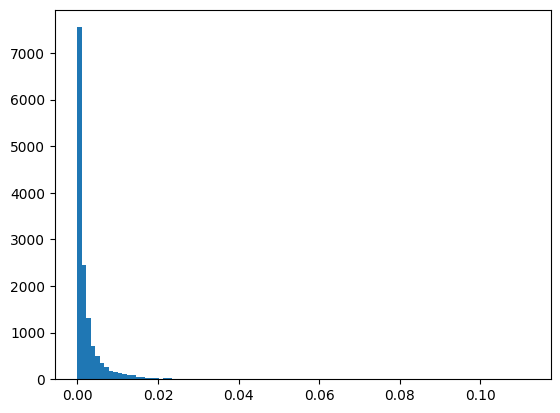

In [78]:
plt.hist(evc_list, bins=100)
plt.xlim()

In [90]:
# get more info about each node
d = {}

for n, kc in res_sorted.items():
    d[n] = (kc, G.degree(n))

df = pd.DataFrame.from_dict(d, orient='index', columns=['KC', 'degree'])

In [91]:
# check 

,KC,degree
ENSG00000171135,1.119497e-01,103
ENSG00000168958,1.091101e-01,97
ENSG00000166257,1.050809e-01,99
ENSG00000141699,1.036721e-01,102
ENSG00000126262,1.025850e-01,101
...,...,...
ENSG00000149043,1.268311e-108,2
ENSG00000166557,1.268311e-108,2
ENSG00000120332,1.268311e-108,2
ENSG00000146555,1.268311e-108,2
